# Fine tuning classification example

We will fine-tune an ada classifier to distinguish between the two emails: Ham and Spam.

In [1]:
import csv
import pandas as pd
import openai

labels=[]
texts=[]

with open('spam_ham_dataset.csv', encoding = 'utf-8') as csv_file_handler:
    csv_reader = csv.DictReader(csv_file_handler)
    for rows in csv_reader:
        labels.append(rows['label'])
        texts.append(rows['text'])       

 ## Data exploration
 The  dataset can be loaded using sklearn. First we will look at the data itself:

In [2]:
print(labels[0])

ham


In [3]:
print(texts[0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


## Data Preparation
We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the list, and the completion is a ham or spam. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [7]:
import pandas as pd
labels=labels[0:300]
texts=texts[0:300]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,Subject: enron methanol ; meter # : 988291\nth...,ham
1,"Subject: hpl nom for january 9 , 2001\n( see a...",ham
2,"Subject: neon retreat\nho ho ho , we ' re arou...",ham
3,"Subject: photoshop , windows , office . cheap ...",spam
4,Subject: re : indian springs\nthis deal is to ...,ham


In [8]:
df.to_json("spams_hams.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [14]:
!pip install --upgrade openai

In [11]:
!openai tools fine_tunes.prepare_data -f spams_hams.jsonl -q

Analyzing...

- Your file contains 300 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 2 duplicated prompt-completion sets. These are rows: [182, 296]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- All prompts start with prefix `Subject: `
- The completion should start with a whitespace character (` `). This tends to produce better results

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

In [12]:
%%script bash
export OPENAI_API_KEY=''
openai api fine_tunes.create -t "spams_hams_prepared_train.jsonl" -v "spams_hams_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " ham" -m ada

Upload progress: 100%|██████████| 286k/286k [00:00<00:00, 142Mit/s]


Uploaded file from spams_hams_prepared_train.jsonl: file-TujTuAlOLumlsutSvCRHUFSk


Upload progress: 100%|██████████| 81.9k/81.9k [00:00<00:00, 64.2Mit/s]


Uploaded file from spams_hams_prepared_valid.jsonl: file-oAEru5XTFnxUS4eMZdfZKj22
Created fine-tune: ft-L3V1Xigw3EkLf9N8PLg38rOd
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-01-12 11:02:29] Created fine-tune: ft-L3V1Xigw3EkLf9N8PLg38rOd
[2023-01-12 11:04:03] Fine-tune costs $0.12
[2023-01-12 11:04:03] Fine-tune enqueued. Queue number: 0
[2023-01-12 11:04:07] Fine-tune started
[2023-01-12 11:04:58] Completed epoch 1/4
[2023-01-12 11:05:37] Completed epoch 2/4
[2023-01-12 11:06:21] Completed epoch 3/4
[2023-01-12 11:07:00] Completed epoch 4/4
[2023-01-12 11:07:22] Uploaded model: ada:ft-personal-2023-01-12-10-07-22
[2023-01-12 11:07:23] Uploaded result file: file-6p3afxKCS08T2trMivRlBE6o
[2023-01-12 11:07:23] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-01-12-10-07-22 -p <YOUR_PROMPT>


The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [16]:
%%script bash
export OPENAI_API_KEY=''
openai api fine_tunes.results -i ft-L3V1Xigw3EkLf9N8PLg38rOd > result.csv

In [15]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
944,945,288713,945,0.030941,1.0,1.0,0.035376,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


The accuracy reaches 100%. On the plot below we can see how accuracy on the validation set increases during the training run. 

<AxesSubplot: >

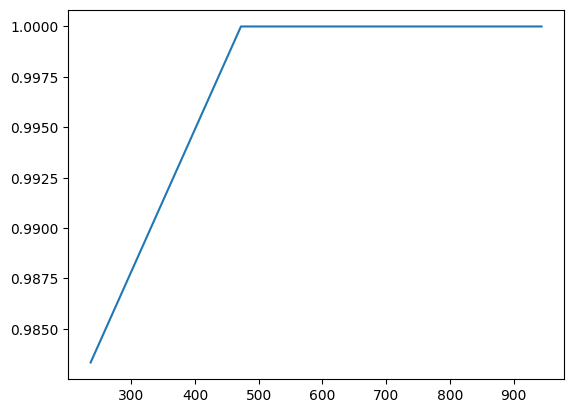

In [17]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

In [18]:
test = pd.read_json('spams_hams_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,"Subject: hpl nom for january 9 , 2001\n( see a...",ham
1,"Subject: photoshop , windows , office . cheap ...",spam
2,Subject: vic . odin n ^ ow\nberne hotbox carna...,spam
3,Subject: fw : ercot load comparison\n- - - - -...,ham
4,"Subject: meter 6461 , concorde churchill\none ...",ham


We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [23]:
openai.api_key = ''
ft_model = 'ada:ft-personal-2023-01-12-10-07-22'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']


' ham'

To get the log probabilities, we can specify logprobs parameter on the completion request

In [21]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7f09a0228130> JSON: {
  " ham": -0.0007079482,
  " spam": -7.307301
}

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.